In [15]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split, ShuffleSplit, GridSearchCV,\
                                    StratifiedKFold, KFold,\
                                    StratifiedShuffleSplit, RepeatedStratifiedKFold, \
                                    cross_val_score, cross_validate
                                    
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import check_random_state
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.decomposition import PCA

from mne.decoding import cross_val_multiscore, LinearModel, \
                         GeneralizingEstimator, Scaler, Vectorizer

import cvxpy as cp

In [4]:
class arguments():
    def __init__(self):
        self.DATAPATH = '../data/'

args = arguments()

train = pd.read_csv(args.DATAPATH + 'studentspen-train.csv')
test = pd.read_csv(args.DATAPATH + 'studentsdigits-test.csv')

X = train[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y = train['Digit'].values
print(X.shape)
print(Y.shape)

(3747, 8)
(3747,)


# Question 4
Question 4) Implement both types of transfer learning SVM (hypothesis and instance transfer) to train 1 vs 7 (target problem) by transferring in 1 vs 9 (source problem). Report your error estimate for the target problem with i) no transfer, ii) hypothesis transfer and iii) instance transfer. Which performs better? Why? (20 points)

In [12]:
fit_intercept=False
def gen_data(fit_intercept):

    grp1 = train[train['Digit']==1]
    grp7 = train[train['Digit']==7]
    grp9 = train[train['Digit']==9]

    if fit_intercept==False:
        grp1['b'] = 1
        grp7['b'] = 1
        grp9['b'] = 1

        X1 = grp1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'b']].values
        Y1 = grp1['Digit'].values

        X7 = grp7[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'b']].values
        Y7 = grp7['Digit'].values

        X9 = grp9[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'b']].values
        Y9 = grp9['Digit'].values
    else:
        X1 = grp1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
        Y1 = grp1['Digit'].values

        X7 = grp7[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
        Y7 = grp7['Digit'].values

        X9 = grp9[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
        Y9 = grp9['Digit'].values

    Y7 = -1*np.ones([Y7.shape[0]])
    Y9 = -1*np.ones([Y9.shape[0]])

    X1_orig = X1.copy()
    Y1_orig = Y1.copy()

    print(X7.shape)
    print(Y7.shape)
    return X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig

In [13]:
def gen_source_target(fit_intercept):
    #--------------------------------------------------------------------------------------
    X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
    #--------------------------------------------------------------------------------------
    # Source
    #--------------------------------------------------------------------------------------
    X19 = np.concatenate((X1, X9),axis=0)
    Y19 = np.concatenate((Y1, Y9),axis=0)

    print(X19.shape, Y19.shape)
    grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
    grp19[:,:-1] = X19
    grp19[:,-1] = Y19
    #--------------------------------------------------------------------------------------
    X_source = X19.copy()
    Y_source = Y19.copy()
    #--------------------------------------------------------------------------------------
    # Target
    #--------------------------------------------------------------------------------------
    X17 = np.concatenate((X1, X7),axis=0)
    Y17 = np.concatenate((Y1, Y7),axis=0)

    print(X19.shape, Y17.shape)
    grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
    grp17[:,:-1] = X17
    grp17[:,-1] = Y17
    #--------------------------------------------------------------------------------------
    X_target = X17.copy()
    Y_target = Y17.copy()
    #--------------------------------------------------------------------------------------
    return X_source, Y_source, X_target, Y_target

In [14]:
# n_split for linear = 10 and for polynomial = 6
n_split_linear=10
n_split_poly=6

cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
cv2 = StratifiedShuffleSplit(n_splits=n_split_poly, random_state=rand_state) 

In [15]:
rand_state=45
max_iter=100000

# No transfer with Sklearn

In [23]:
clf_src = make_pipeline(StandardScaler(), LinearSVC(random_state=rand_state, \
                                                                max_iter=max_iter, \
                                                                fit_intercept=fit_intercept))

bsvc_tr = make_pipeline(StandardScaler(), SVC(kernel='linear', \
                                                          random_state=rand_state, \
                                                          max_iter=max_iter))

### conclustion:
only LinearSVC has fit_intercept, so to be able to augment data and not use intercept, I prefer to use this, however, most of the times SVC with kernel='linear' gives a better score. So here I have checked it and it seems the scores of both LinearSVC and SVC with kernel='linear' are pretty close. So I will use LinearSVC at the end with fit_intercept=False.

In [24]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#--------------------------------------------------------------------------------------
#--------------------------------------------------------------------------------------
# Source
#--------------------------------------------------------------------------------------
X19 = np.concatenate((X1, X9),axis=0)
Y19 = np.concatenate((Y1, Y9),axis=0)

print(X19.shape, Y19.shape)
grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
grp19[:,:-1] = X19
grp19[:,-1] = Y19
#--------------------------------------------------------------------------------------
X_source = X19.copy()
Y_source = Y19.copy()
#--------------------------------------------------------------------------------------
print(' Source Scores ---------------------')
clf_src_scores1    = cross_val_score(bsvc_tr, X_source, Y_source, cv=cv1, n_jobs=1)
# print(clf_src_scores1)
print(np.mean(clf_src_scores1))
print('------------------------------------')
clf_trg_scores2    = cross_val_score(clf_src, X_source, Y_source, cv=cv1, n_jobs=1)
# print(clf_trg_scores2)
print(np.mean(clf_trg_scores2))
print('------------------------------------')


#--------------------------------------------------------------------------------------
# Target
#--------------------------------------------------------------------------------------
X17 = np.concatenate((X1, X7),axis=0)
Y17 = np.concatenate((Y1, Y7),axis=0)

print(X19.shape, Y17.shape)
grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
grp17[:,:-1] = X17
grp17[:,-1] = Y17

#--------------------------------------------------------------------------------------
X_target = X17.copy()
Y_target = Y17.copy()
#--------------------------------------------------------------------------------------
print(' Target Scores ---------------------')
clf_trg_scores1    = cross_val_score(bsvc_tr, X_target, Y_target, cv=cv1, n_jobs=1)
# print(clf_trg_scores1)
print(np.mean(clf_trg_scores1))
print('------------------------------------')
clf_trg_scores2    = cross_val_score(clf_src, X_target, Y_target, cv=cv1, n_jobs=1)
# print(clf_trg_scores2)
print(np.mean(clf_trg_scores2))
print('------------------------------------')


/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

(374, 9)
(374,)
(374, 9)
(374,)
(747, 9) (747,)
(747, 9) (764,)
(747, 9) (747,)
 Source Scores ---------------------
0.8986666666666666
------------------------------------
0.8946666666666665
------------------------------------
(747, 9) (764,)
 Target Scores ---------------------
0.8740259740259739
------------------------------------
0.8701298701298701
------------------------------------


## check if I get the same score with a solver
### Conclusion: even though every time the index for train and test are different but at the end the average over all epochs is same! so all epochs have same performance!! 

In [25]:
def calc_perf(x1, x2):
    nn = x1.shape[0]
    scores = np.zeros([nn, 1])
    for ii in range(nn):
        if x1[ii]==x2[ii]:
            scores[ii] = 1
        else:
            scores[ii] = 0
    corr = np.sum(scores, axis=0)
    perf = (corr / nn) * 100
    return corr, perf

def calc_err(x1, x2):
    nn = x1.shape[0]
    scores = np.zeros([nn, 1])
    for ii in range(nn):
        if x1[ii]!=x2[ii]:
            scores[ii] = 1
        else:
            scores[ii] = 0
    incorr = np.sum(scores, axis=0)
    incorr_prcng = (incorr / nn) * 100
    return incorr, incorr_prcng

# No transfer - With Solver

Conclusion: I have check adding "(1 - epsilon.value)" when I was calculating scores, some notes:
        
This is only for train data since I created epsilon only for training data and not test, 

I got worse peformance when I used it (train: 69.63609898%, test: 87.53246753) compare to when I do not add this (train: 89.82532751%, test: 87.53246753)

Still having the issue that everything is same over blocks!

In [30]:
n_epochs=10
C=1

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

(374, 9)
(374,)
(374, 9)
(374,)
(747, 9) (747,)
(747, 9) (764,)
epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
[[89.6797671]
 [89.6797671]
 [89.6797671]
 [89.6797671]
 [89.6797671]
 [89.6797671]
 [89.6797671]
 [89.6797671]
 [89.6797671]
 [89.6797671]]
[[86.49350649]
 [86.49350649]
 [86.49350649]
 [86.49350649]
 [86.49350649]
 [86.49350649]
 [86.49350649]
 [86.49350649]
 [86.49350649]
 [86.49350649]]


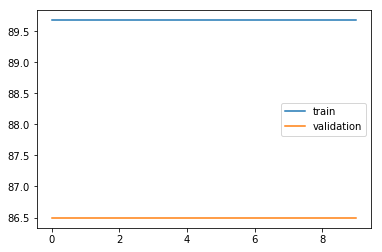

In [31]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#--------------------------------------------------------------------------------------
X17 = X_target.copy()
Y17 = Y_target.copy()
#--------------------------------------------------------------------------------------
cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
#--------------------------------------------------------------------------------------
corrs_train = np.zeros([n_epochs, n_split_linear, 1])
perfs_train = np.zeros([n_epochs, n_split_linear, 1])
corrs_test = np.zeros([n_epochs, n_split_linear, 1])
perfs_test = np.zeros([n_epochs, n_split_linear, 1])
#--------------------------------------------------------------------------------------
for ep, epochs in enumerate(range(n_epochs)):
    cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
    print('epoch:', ep)
    ii=0
    for trg_train_index, trg_test_index in cv1.split(X17, Y17):
        X_train = X17[trg_train_index,:].copy()
        y_train = Y17[trg_train_index].copy()
        y_train = y_train[:, np.newaxis]
        #----------------------------------------------------------------------------------
        X_test = X17[trg_test_index,:].copy()
        y_test = Y17[trg_test_index].copy()
        #----------------------------------------------------------------------------------
        D = X_train.shape[1]# feature dimension
        N = X_train.shape[0]
        epsilon = cp.Variable((N, 1))
        w = cp.Variable((D, 1))
        P = np.diag(np.ones(D))
        #----------------------------------------------------------------------------------
        objective = cp.Minimize(cp.sum_squares(w) * 0.5 + cp.sum(cp.square(epsilon)*C))
        constraints = [cp.multiply(y_train, (X_train @ w)) >= 1 - epsilon, epsilon >= 0]
        prob = cp.Problem(objective, constraints)
        prob.solve()
        #----------------------------------------------------------------------------------
        y_test_pred = np.sign(X_test.dot(w.value))
        corr, perf = calc_perf(y_test_pred, y_test)
        corrs_test[ep, ii]=corr
        perfs_test[ep, ii]=perf
        #----------------------------------------------------------------------------------
        y_train_pred = np.sign(X_train.dot(w.value))
        corr, perf = calc_perf(y_train_pred, y_train)
        corrs_train[ep, ii]=corr
        perfs_train[ep, ii]=perf
        #----------------------------------------------------------------------------------
        ii+=1
#-----------------------------------------------------------------------------------------
corrs_epch_test = np.mean(corrs_test, axis=1)
perfs_epch_test = np.mean(perfs_test, axis=1)
corrs_epch_train = np.mean(corrs_train, axis=1)
perfs_epch_train = np.mean(perfs_train, axis=1)
#-----------------------------------------------------------------------------------------
print(perfs_epch_train)
print(perfs_epch_test)
plt.plot(range(n_epochs), perfs_epch_train, label='train')
plt.plot(range(n_epochs), perfs_epch_test, label='validation')
plt.legend()
#-----------------------------------------------------------------------------------------

# Hypothesis Transfer with Solver 
good link for tuning C/lambda: https://www.cvxpy.org/examples/machine_learning/svm.html

In [32]:
clf_src = make_pipeline(StandardScaler(), LinearSVC(random_state=rand_state, \
                                                                max_iter=max_iter, \
                                                                fit_intercept=fit_intercept))

In [33]:
#--------------------------------------------------------------------------------------
n_epochs=10
#--------------------------------------------------------------------------------------
# featW=True #train~ 90, validation < 30
featW=False #train~ 93, validation ~ 88
#--------------------------------------------------------------------------------------
# If featW was True set this to False! They should be doing similar
dublicateX1=True
#--------------------------------------------------------------------------------------
# range_n_splits=[5,10,20] # It seems split=10 could be reasonable one
range_n_splits=[10]
#--------------------------------------------------------------------------------------
# testSizes=[0.1, 0.2, 0.3, 0.4, 0.5] # It seems, 0.3 could be a reaonable one
testSizes=[0.5]
#--------------------------------------------------------------------------------------
TRIALS = 10
C_vals = np.logspace(-1, 0, TRIALS)

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

(374, 9)
(374,)
10
[89.48762737 89.48617176 89.46724891 89.47889374 89.47161572 89.48034934
 89.48762737 89.48908297 89.48326055 89.48180495]
[89.20779221 89.20779221 89.22077922 89.25974026 89.23376623 89.23376623
 89.22077922 89.19480519 89.19480519 89.15584416]


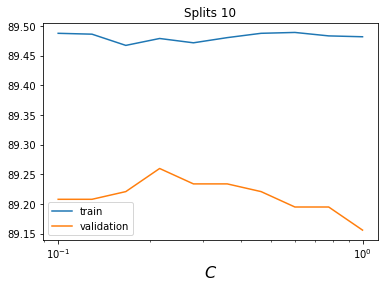

In [34]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
#--------------------------------------------------------------------------------------

for nsp in range_n_splits:
    corrs_train = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_train = np.zeros([nsp, n_split_linear, TRIALS])
    corrs_test = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_test = np.zeros([nsp, n_split_linear, TRIALS])
    print(nsp)
    #-----------------------------------------------------------------------------------------
    for ts in testSizes:
        #--------------------------------------------------------------------------------------
        cv = StratifiedShuffleSplit(n_splits=nsp, random_state=rand_state, test_size=ts)
        #--------------------------------------------------------------------------------------
        if dublicateX1: 
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
            X1 = np.concatenate((X1, X1), axis=0)
            Y1 = np.concatenate((Y1, Y1), axis=0)
        else:
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
        #--------------------------------------------------------------------------------------
        for x1fld, (X1_src_tr_index, X1_trg_te_index) in enumerate(cv.split(X1, Y1)):
            #----------------------------------------------------------------------------------
            #print('X1 target shape', X1[X1_trg_te_index].shape, 'X7 source shape', X7.shape)
            #print('-------------------------------------------------')
            #print('X1 source shape', X1[X1_src_tr_index].shape, 'X9 target shape', X9.shape, '\n')
            X17 = np.concatenate((X1[X1_trg_te_index], X7),axis=0)
            Y17 = np.concatenate((Y1[X1_trg_te_index], Y7),axis=0)
            grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
            grp17[:,:-1] = X17
            grp17[:,-1] = Y17
            #------
            X19 = np.concatenate((X1[X1_src_tr_index,:], X9),axis=0)
            Y19 = np.concatenate((Y1[X1_src_tr_index], Y9),axis=0)
            grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
            grp19[:,:-1] = X19
            grp19[:,-1] = Y19
            #----------------------------------------------------------------------------------
            X_source = X19.copy()
            Y_source = Y19.copy()
            #------
            X_target = X17.copy()
            Y_target = Y17.copy()
            #----------------------------------------------------------------------------------
            # I calculated this way so the one with fewer samples would have more weight, so the 
            # enumerator is same and the denomerator is the number of samples
            Imp1 =   X_target.shape[0] / X1[X1_trg_te_index].shape[0]
            Imp7 =   X_target.shape[0] / X7.shape[0]
            #----------------------------------------------------------------------------------
            cv2 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state)
            #----------------------------------------------------------------------------------
            for cvtrgt, (trg_train_index, trg_test_index) in enumerate(cv2.split(X17, Y17)):
                #----------------------------------------------------------------------------------
                X_train = X17[trg_train_index,:].copy()
                y_train = Y17[trg_train_index].copy()
                y_train = y_train[:, np.newaxis]
                #----------------------------------------------------------------------------------
                X_test = X17[trg_test_index,:].copy()
                y_test = Y17[trg_test_index].copy()
                #----------------------------------------------------------------------------------        
                clf_src.fit(X_source, Y_source)
                #----------------------------------------------------------------------------------
                epsilon = cp.Variable((X_train.shape[0], 1))
                w_source = clf_src.named_steps['linearsvc'].coef_.T
                D = X_train.shape[1]# feature dimension
                N = X_train.shape[0]
                P = np.diag(np.ones(D))
                w_d = cp.Variable((D, 1))
                w_d.value = w_source
                #----------------------------------------------------------------------------------
                X=X_train.copy()
                y=y_train.copy()
                C = cp.Parameter(nonneg=True)
                objective = cp.Minimize(cp.sum_squares(w_d) * 0.5 + cp.sum(cp.square(epsilon)*C))
                #----------------------------------------------------------------------------------
                if featW:
                    Imp=[]
                    for yy in y_train:
                        if yy == 1:
                            Imp.append(Imp1*yy)
                        elif yy == -1:
                            Imp.append(Imp7*yy)
                    Imp = np.asarray(Imp)        
                    constraints = [cp.multiply(cp.multiply(Imp, y), \
                                   (X @ (w_source + w_d))) >= 1 - epsilon, \
                                   epsilon >= 0]
                else:
                    constraints = [cp.multiply(y, \
                                   (X @ (w_source + w_d))) >= 1 - epsilon, \
                                   epsilon >= 0]
                #----------------------------------------------------------------------------------
                prob = cp.Problem(objective, constraints)
                #----------------------------------------------------------------------------------
                # Compute a trade-off curve and record train and test error.                        
                for cc in range(TRIALS):
                    C.value = C_vals[cc]
                    prob.solve()
                    #----------------------------------------------------------------------------------
                    w_trgt = w_source + w_d
                    #----------------------------------------------------------------------------------
                    y_test_pred = np.sign(X_test.dot(w_trgt.value))
                    corr, perf = calc_err(y_test_pred, y_test)
                    corr, perf = calc_perf(y_test_pred, y_test)
                    corrs_test[x1fld, cvtrgt, cc]=corr
                    perfs_test[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
                    y_train_pred = np.sign(X_train.dot(w_trgt.value))
                    corr, perf = calc_err(y_train_pred, y_train)
                    corr, perf = calc_perf(y_train_pred, y_train)
                    corrs_train[x1fld, cvtrgt, cc]=corr
                    perfs_train[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
    train_scores_flds     = np.mean(perfs_train, axis=0)
    validation_scores_flds= np.mean(perfs_test, axis=0)
    train_scores_flds     = np.mean(train_scores_flds, axis=0)
    validation_scores_flds= np.mean(validation_scores_flds, axis=0)
    #------------------------------------------------------------------------------------------    
    print(train_scores_flds)
    print(validation_scores_flds)
    #------------------------------------------------------------------------------------------
    plt.plot(C_vals, train_scores_flds, label='train')
    plt.plot(C_vals, validation_scores_flds, label='validation')
    plt.xlabel(r"$C$", fontsize=16)
    plt.xscale('log')
    plt.title('Splits %s' %(nsp))
    plt.legend()
    plt.show()

Check the results for tuning regularizarion term lambda/C, (n_split chose to be 10, and test_size to 0.5)

Conclusion: it turns out C=0.21 is the best

In [35]:
best_C_hypo = np.argmax(validation_scores_flds)
print('best C is: ', C_vals[best_C_hypo])
print(perfs_train.shape)
print(best_C_hypo)
best_score_train      = np.mean(perfs_train[:,:, best_C_hypo], axis=(0,1))
best_score_validation = np.mean(perfs_test[:,:, best_C_hypo], axis=(0,1))
print(best_score_train, best_score_validation)

best C is:  0.21544346900318834
(10, 10, 10)
3
89.47889374090249 89.25974025974024


## plot hypothesis transfer learning

In [ ]:
def plot_transfer_hyperplane(X_plt, y_plt, clf_src, problem, sv_method, use_annotate):
    leg_label=''
    if problem=='target':
        pca = PCA(n_components=2).fit(X_plt)
        pca_2d = pca.transform(X_plt)
        leg_label = 'digit 7'
    elif problem=='source':
        pca = PCA(n_components=2).fit(X_plt)
        pca_2d = pca.transform(X_plt)
        leg_label = 'digit 9'

    fig = plt.figure(figsize=(12, 12))
    ax  = fig.add_subplot(111)

    for i in range(0, pca_2d.shape[0]):
        if y_plt[i] == 1:
            c0 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c='r', marker='+', s=100)
        elif y_plt[i] == -1:
            c1 = plt.scatter(pca_2d[i,0], pca_2d[i,1], c='b', marker='X', s=100)
        if use_annotate:
            ax.annotate(str(y_plt[i]), (pca_2d[i,0],pca_2d[i,1]))
    #----------------------------------------------------------------------------------               
    plt.title('Instance Transfer for %s Problem \n Using %s for Getting Support Vectors' %(problem, sv_method),\
             fontweight='bold', fontsize=22)
    #----------------------------------------------------------------------------------  
    svclassifier_2d = clf_src
    svclassifier_2d.fit(pca_2d, y_plt)
    #----------------------------------------------------------------------------------  
    decision_function = svclassifier_2d.named_steps['linearsvc'].decision_function(pca_2d)
    #----------------------------------------------------------------------------------  
    if sv_method=='linearSVC':
        support_vector_indices = np.where((y_plt) * decision_function <= 1)[0]
    elif sv_method=='solver':
        eps=1
        sup = y_plt * decision_function
        support_vector_indices = np.where((-eps<sup) & (sup<eps))[0]
    #----------------------------------------------------------------------------------  
    sup_vecs = pca_2d[support_vector_indices]
    #----------------------------------------------------------------------------------  
    for i in range(0, pca_2d.shape[0]):
        if np.sum(support_vector_indices==i)==1:
            if y_plt[i] == 1:
                c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1], c='y',  marker='+', s=200)
            if y_plt[i] == -1:
                c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1], c='g',  marker='X', s=200)

    plt.legend([c0, c1, c2, c3],['digit 1', '%s' %leg_label, 'support_vecs +', 'support_vecs -'])
    #----------------------------------------------------------------------------------  
    x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
    y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),   np.arange(y_min, y_max, 10))

    Z = svclassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z)
    plt.axis('off')
    plt.show()
    #----------------------------------------------------------------------------------  
    print('done')

In [52]:
clf_src_best = make_pipeline(StandardScaler(), LinearSVC(C=, random_state=rand_state, \
                                                         max_iter=max_iter, \
                                                         fit_intercept=fit_intercept))

In [53]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#--------------------------------------------------------------------------------------

(374, 9)
(374,)
(374, 9)
(374,)
(747, 9) (747,)
(747, 9) (764,)


/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

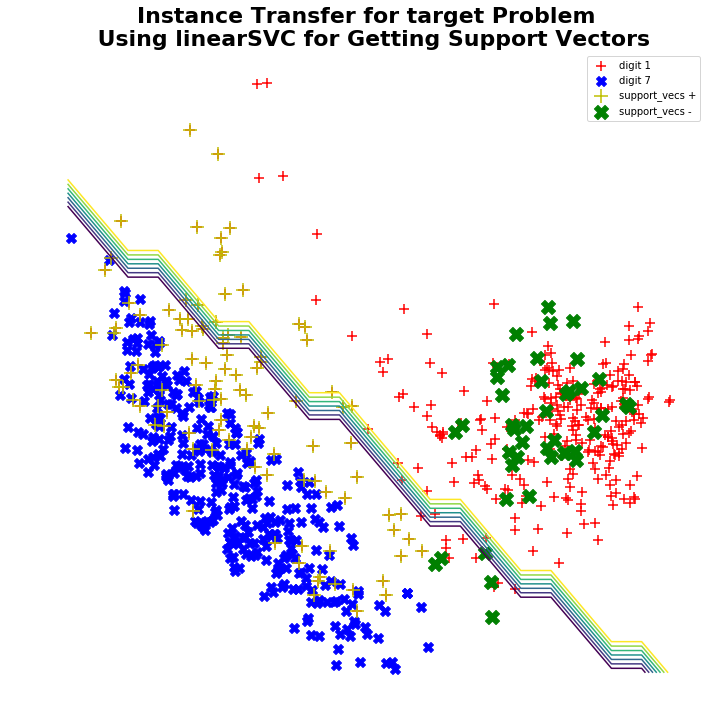

done


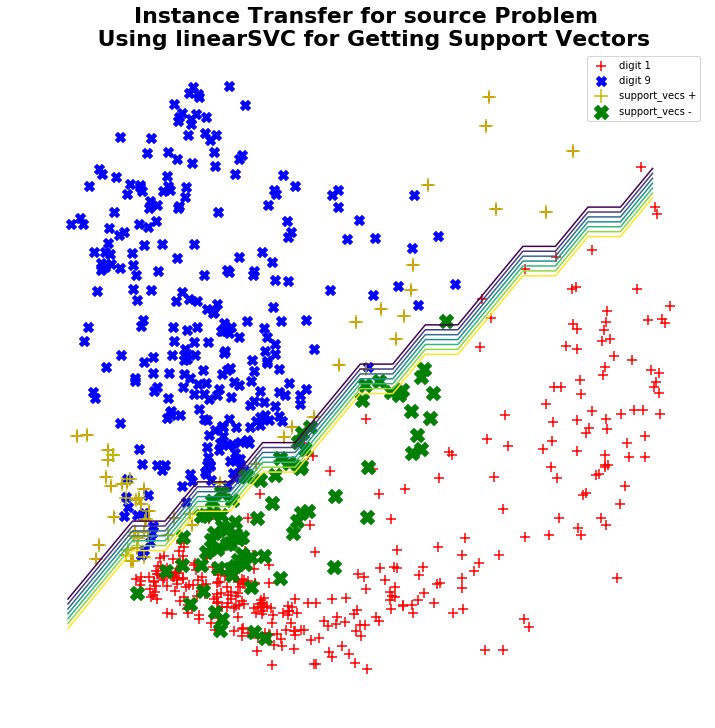

done


In [65]:
use_annotate=False
plot_transfer_hyperplane(X_plt=X_target.copy(), y_plt=Y_target.copy(), clf_src=clf_src_best, problem='target', sv_method='linearSVC', use_annotate=use_annotate)
plot_transfer_hyperplane(X_plt=X_source.copy(), y_plt=Y_source.copy(), clf_src=clf_src_best, problem='source', sv_method='linearSVC', use_annotate=use_annotate)

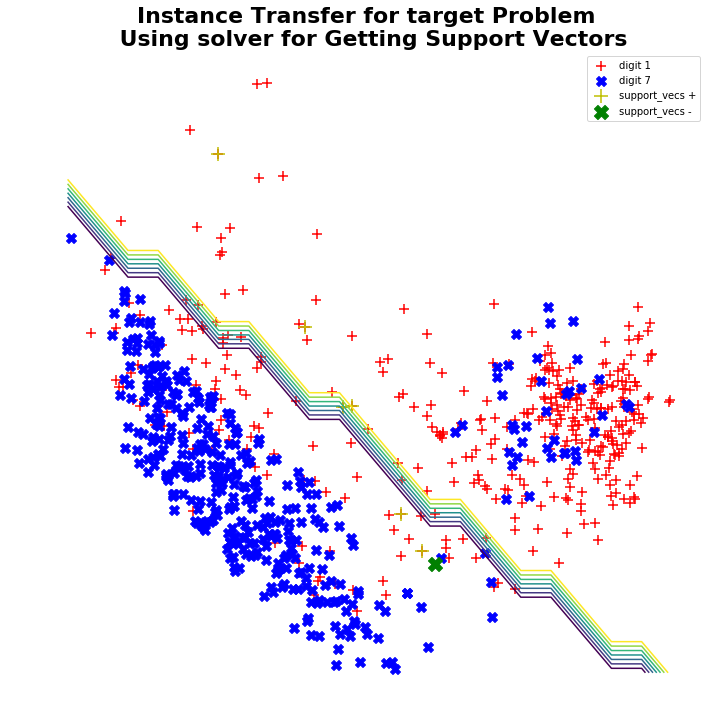

done


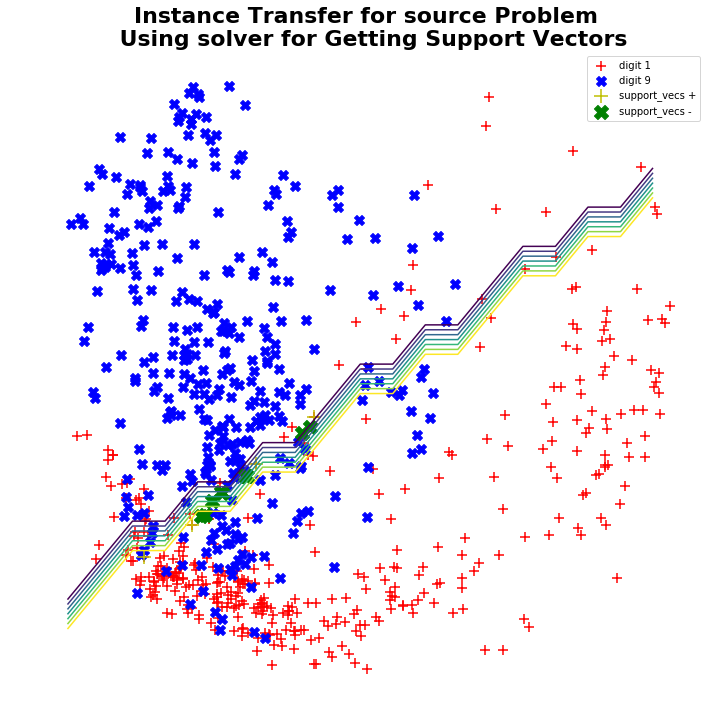

done


In [66]:
plot_transfer_hyperplane(X_plt=X_target.copy(), y_plt=Y_target.copy(),\
                         clf_src=clf_src_best, problem='target', sv_method='solver', use_annotate=use_annotate)
plot_transfer_hyperplane(X_plt=X_source.copy(), y_plt=Y_source.copy(), \
                         clf_src=clf_src_best, problem='source', sv_method='solver', use_annotate=use_annotate)

# Instance Learning

#### First check how to get support vectors:
some notes;

LinearSVC does not give support vectors but it has fit_intercept boolean and I augnemnted all of my data so I want to use this boolean

however, SVC that gives support vectors as output does not have the boolearn fit_intercept

So the question is how to get support vectors out of LinearSVC and whether it is same when I use SVC


In [88]:
clf_src = make_pipeline(StandardScaler(), LinearSVC(random_state=rand_state, \
                                                    max_iter=max_iter, \
                                                    fit_intercept=fit_intercept))
bsvc_tr = make_pipeline(StandardScaler(), SVC(kernel='linear', \
                                              random_state=rand_state, \
                                              max_iter=max_iter))

In [94]:
#--------------------------------------------------------------------------------------
n_epochs=10
#--------------------------------------------------------------------------------------
# featW=True #train~ 90, validation < 30
featW=False #train~ 93, validation ~ 88
#--------------------------------------------------------------------------------------
# If featW was True set this to False! They should be doing similar
dublicateX1=True
#--------------------------------------------------------------------------------------
# range_n_splits=[5,10,20] # It seems split=10 could be reasonable one
range_n_splits=[10]
#--------------------------------------------------------------------------------------
# testSizes=[0.1, 0.2, 0.3, 0.4, 0.5] # It seems, 0.3 could be a reaonable one
testSizes=[0.5]
#--------------------------------------------------------------------------------------
TRIALS = 10
C_vals = np.logspace(-1, 0, TRIALS)

In [95]:
eps = 1e-8 # select support vectors

In [96]:
bsvc_tr.named_steps

{'standardscaler': StandardScaler(copy=True, with_mean=True, with_std=True),
 'svc': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
     kernel='linear', max_iter=100000, probability=False, random_state=45,
     shrinking=True, tol=0.001, verbose=False)}

### Checking how to get support vectors
I have compared SVC, LinearSVC and solver for all source data. So it seems SVC and LinearSVC ae more flexible and cosider all data below<=1 as support vectors, however, in solver, TA only transferred those that are very close to 1. The way he did it is: defined an epsilon (eps), because it wont be well defined to only say supportvecotrs==1, so he defined a VERY SMALL epsilon (eps) and said -eps < supportvectors - 1 <eps which means supportvectors - 1 is very close to zero or in other words it is very close to 1. 

In [97]:
#----------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#----------------------------------------------------------------------------------
clf_src.fit(X_source, Y_source)
bsvc_tr.fit(X_source, Y_source)
#----------------------------------------------------------------------------------        
# using this link 
# https://scikit-learn.org/stable/auto_examples/svm/plot_linearsvc_support_vectors.html
decision_function = clf_src.named_steps['linearsvc'].decision_function(X_source)
# we can also calculate the decision function manually
# decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
support_vector_indices = np.where((Y_source) * decision_function <= 1)[0]
sv_X = X_source[support_vector_indices]
sv_y = Y_source[support_vector_indices]
print('support_vectors1------', sv_X.shape)
#----------------------------------------------------------------------------------        
support_vectors = bsvc_tr.named_steps['svc'].support_vectors_
print('support_vectors2------', support_vectors.shape)
#----------------------------------------------------------------------------------        
# Ge's code
D = X_source.shape[1]# feature dimension
N = X_source.shape[0]
epsilon = cp.Variable((N, 1))
sv_epsilon = cp.Variable((support_vector_indices.shape[0], 1))
w = cp.Variable((D, 1))
P = np.diag(np.ones(D))
objective = cp.Minimize(cp.sum_squares(w) * 0.5 + cp.sum(cp.square(epsilon)*C))
Y_source=Y_source[:,np.newaxis]
constraints = [cp.multiply(Y_source, (X_source @ w)) >= 1 - epsilon, epsilon >= 0]
prob = cp.Problem(objective, constraints)
prob.solve()

eps_range=[1e-15, 1e-14, 1e-8, 1e-2, 1e-1]
for eps in eps_range:
    print('*****',Y_source.shape, w.shape, X_source.shape)
    sup = Y_source*(X_source.dot(w.value)) - 1
    sup_v1 = ((-eps<sup) & (sup<eps)).flatten()
    print('eps', eps, '; support_vectors3_1------', np.sum((sup_v1).astype(int)))
    print('\n')

/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

(374, 9)
(374,)
(374, 9)
(374,)
(747, 9) (747,)
(747, 9) (764,)
support_vectors1------ (215, 9)
support_vectors2------ (205, 9)
***** (747, 1) (9, 1) (747, 9)
eps 1e-15 ; support_vectors3_1------ 0


***** (747, 1) (9, 1) (747, 9)
eps 1e-14 ; support_vectors3_1------ 0


***** (747, 1) (9, 1) (747, 9)
eps 1e-08 ; support_vectors3_1------ 0


***** (747, 1) (9, 1) (747, 9)
eps 0.01 ; support_vectors3_1------ 11


***** (747, 1) (9, 1) (747, 9)
eps 0.1 ; support_vectors3_1------ 79




(374, 9)
(374,)
10


/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

support_vectors1------ (11,)
[87.67540029 87.68704512 87.69286754 87.71615721 87.70305677 87.69868996
 87.70014556 87.70305677 87.71615721 87.70742358]
[87.75324675 87.77922078 87.77922078 87.77922078 87.68831169 87.67532468
 87.66233766 87.66233766 87.64935065 87.66233766]


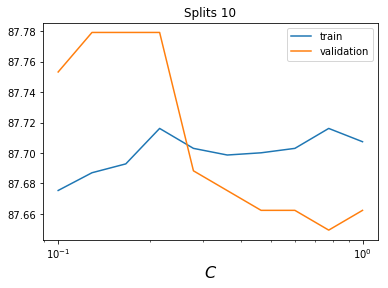

In [98]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
#--------------------------------------------------------------------------------------

for nsp in range_n_splits:
    corrs_train = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_train = np.zeros([nsp, n_split_linear, TRIALS])
    corrs_test = np.zeros([nsp, n_split_linear, TRIALS])
    perfs_test = np.zeros([nsp, n_split_linear, TRIALS])
    print(nsp)
    #-----------------------------------------------------------------------------------------
    for ts in testSizes:
        #--------------------------------------------------------------------------------------
        cv = StratifiedShuffleSplit(n_splits=nsp, random_state=rand_state, test_size=ts)
        #--------------------------------------------------------------------------------------
        if dublicateX1: 
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
            X1 = np.concatenate((X1, X1), axis=0)
            Y1 = np.concatenate((Y1, Y1), axis=0)
        else:
            X1 = X1_orig.copy()
            Y1 = Y1_orig.copy()
        #--------------------------------------------------------------------------------------
        for x1fld, (X1_src_tr_index, X1_trg_te_index) in enumerate(cv.split(X1, Y1)):
            #----------------------------------------------------------------------------------
            #print('X1 target shape', X1[X1_trg_te_index].shape, 'X7 source shape', X7.shape)
            #print('-------------------------------------------------')
            #print('X1 source shape', X1[X1_src_tr_index].shape, 'X9 target shape', X9.shape, '\n')
            X17 = np.concatenate((X1[X1_trg_te_index], X7),axis=0)
            Y17 = np.concatenate((Y1[X1_trg_te_index], Y7),axis=0)
            grp17 = np.zeros([X17.shape[0], X17.shape[1]+1])
            grp17[:,:-1] = X17
            grp17[:,-1] = Y17

            X19 = np.concatenate((X1[X1_src_tr_index,:], X9),axis=0)
            Y19 = np.concatenate((Y1[X1_src_tr_index], Y9),axis=0)
            grp19 = np.zeros([X19.shape[0], X19.shape[1]+1])
            grp19[:,:-1] = X19
            grp19[:,-1] = Y19
            #----------------------------------------------------------------------------------
            X_source = X19.copy()
            Y_source = Y19.copy()

            X_target = X17.copy()
            Y_target = Y17.copy()
            #----------------------------------------------------------------------------------
            # I calculated this way so the one with fewer samples would have more weight, so the 
            # enumerator is same and the denomerator is the number of samples
            Imp1 =   X_target.shape[0] / X1[X1_trg_te_index].shape[0]
            Imp7 =   X_target.shape[0] / X7.shape[0]
            #----------------------------------------------------------------------------------
            cv2 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state)
            #----------------------------------------------------------------------------------
            for cvtrgt, (trg_train_index, trg_test_index) in enumerate(cv2.split(X17, Y17)):
                #----------------------------------------------------------------------------------
                X_train = X17[trg_train_index,:].copy()
                y_train = Y17[trg_train_index].copy()
                y_train = y_train[:, np.newaxis]
                #----------------------------------------------------------------------------------
                X_test = X17[trg_test_index,:].copy()
                y_test = Y17[trg_test_index].copy()
                #----------------------------------------------------------------------------------        
                clf_src.fit(X_source, Y_source)
                #----------------------------------------------------------------------------------  
                decision_function = clf_src.named_steps['linearsvc'].decision_function(X_source)                
#                 support_vector_indices = np.where((Y_source) * decision_function <= 1)[0]
                eps=1
                sup = Y_source * decision_function
                support_vector_indices = np.where((-eps<sup) & (sup<eps))[0]

                
                sv_X = X_source[support_vector_indices]
                sv_y = Y_source[support_vector_indices]
                sv_y = sv_y[:,np.newaxis]
                
                #----------------------------------------------------------------------------------
                epsilon     = cp.Variable((X_train.shape[0], 1))        
                epsilon_src = cp.Variable((support_vector_indices.shape[0], 1))
                P = np.diag(np.ones(D))
                w = cp.Variable((D, 1))
                C     = cp.Parameter(nonneg=True)
                C_src = cp.Parameter(nonneg=True)
                #----------------------------------------------------------------------------------
                X=X_train.copy()
                y=y_train.copy()
                #----------------------------------------------------------------------------------
                objective = cp.Minimize(cp.sum_squares(w) * 0.5 + cp.sum(cp.square(epsilon)*C) + \
                                        cp.sum(cp.square(epsilon_src)*C_src))
                #----------------------------------------------------------------------------------
                if featW:
                    Imp=[]
                    for yy in y_train:
                        if yy == 1:
                            Imp.append(Imp1*yy)
                        elif yy == -1:
                            Imp.append(Imp7*yy)
                    Imp = np.asarray(Imp)       
                    constraints = [cp.multiply(cp.multiply(Imp, y), (X_source @ w)) >= 1 - epsilon, epsilon >= 0, \
                                   cp.multiply(sv_y, (sv_X @ w)) >= 1 - epsilon_src, epsilon_src>=0]
                else:
                    constraints = [cp.multiply(y, (X @ w)) >= 1 - epsilon, epsilon >= 0, \
                                   cp.multiply(sv_y, (sv_X @ w)) >= 1 - epsilon_src, epsilon_src>=0]
                #----------------------------------------------------------------------------------
                prob = cp.Problem(objective, constraints)
                #----------------------------------------------------------------------------------
                # Compute a trade-off curve and record train and test error.                        
                for cc in range(TRIALS):
                    C.value = C_vals[cc]
                    C_src.value = C_vals[cc]
                    prob.solve()
                    #----------------------------------------------------------------------------------
                    y_test_pred = np.sign(X_test.dot(w.value))
                    corr, perf = calc_err(y_test_pred, y_test)
                    corr, perf = calc_perf(y_test_pred, y_test)
                    corrs_test[x1fld, cvtrgt, cc]=corr
                    perfs_test[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
                    y_train_pred = np.sign(X_train.dot(w.value))
                    corr, perf = calc_err(y_train_pred, y_train)
                    corr, perf = calc_perf(y_train_pred, y_train)
                    corrs_train[x1fld, cvtrgt, cc]=corr
                    perfs_train[x1fld, cvtrgt, cc]=perf
                    #----------------------------------------------------------------------------------
    print('support_vectors1------', support_vector_indices.shape)                
    train_scores_flds     = np.mean(perfs_train, axis=0)
    validation_scores_flds= np.mean(perfs_test, axis=0)
    train_scores_flds     = np.mean(train_scores_flds, axis=0)
    validation_scores_flds= np.mean(validation_scores_flds, axis=0)
    #------------------------------------------------------------------------------------------    
    print(train_scores_flds)
    print(validation_scores_flds)
    #------------------------------------------------------------------------------------------
    plt.plot(C_vals, train_scores_flds, label='train')
    plt.plot(C_vals, validation_scores_flds, label='validation')
    plt.xlabel(r"$C$", fontsize=16)
    plt.xscale('log')
    plt.title('Splits %s' %(nsp))
    plt.legend()
    plt.show()

In [99]:
best_C_inst = np.argmax(validation_scores_flds)
print('best C is: ', C_vals[best_C_inst])
print(perfs_train.shape)
print(best_C_inst)
best_score_train      = np.mean(perfs_train[:,:, best_C_inst], axis=(0,1))
best_score_validation = np.mean(perfs_test[:,:, best_C_inst], axis=(0,1))
print(best_score_train, best_score_validation)

best C is:  0.1291549665014884
(10, 10, 10)
1
87.6870451237263 87.77922077922078


In [102]:
clf_src_best_inst = make_pipeline(StandardScaler(), LinearSVC(C=best_C_inst, random_state=rand_state, \
                                                         max_iter=max_iter, \
                                                         fit_intercept=fit_intercept))

## plot results

In [105]:
#--------------------------------------------------------------------------------------
X1, Y1, X7, Y7, X9, Y9, X1_orig, Y1_orig = gen_data(fit_intercept)
X_source, Y_source, X_target, Y_target = gen_source_target(fit_intercept)
#--------------------------------------------------------------------------------------
X_source_plt = X_source.copy()
y_source_plt = Y_source.copy()
X_target_plt = X_target.copy()
y_target_plt = Y_target.copy()
#--------------------------------------------------------------------------------------
prob='target'
leg_label=''
#--------------------------------------------------------------------------------------

(374, 9)
(374,)
(374, 9)
(374,)
(747, 9) (747,)
(747, 9) (764,)


/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/Maryam/anaconda3/envs/DeepLearningEEG/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to

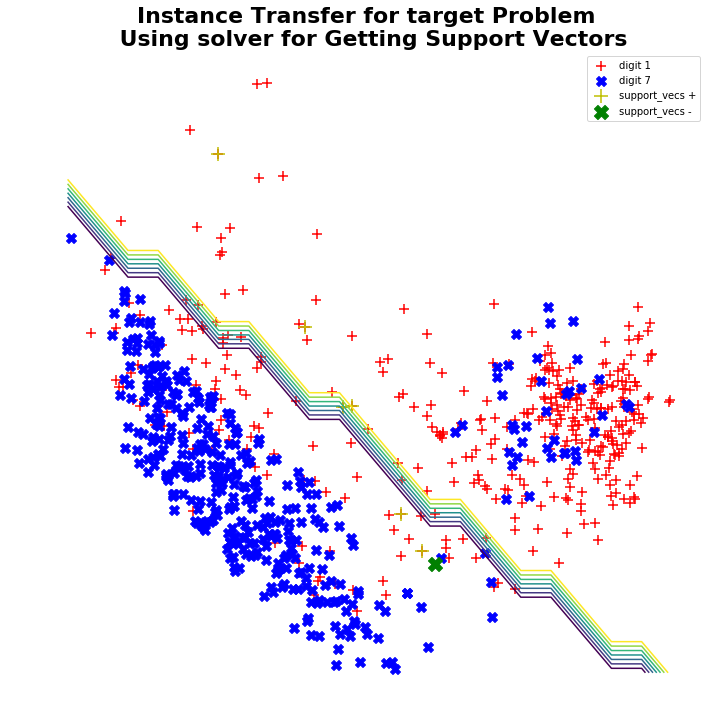

done


In [108]:
plot_transfer_hyperplane(X_plt=X_target.copy(), y_plt=Y_target.copy(), \
                         clf_src=clf_src_best_inst, problem='target', sv_method='solver', use_annotate=use_annotate)

# Checking classifiers after adding kernel
seems kernel='poly' is the best one

In [ ]:
def plot_multiclass_hyperplane(X_plt, y_plt, clf_src, use_annotate):
    #----------------------------------------------------------------------------------               
    fig= plt.figure(figsize=(13,13))
    ax = fig.add_subplot(111)
    #----------------------------------------------------------------------------------               
    pca = PCA(n_components=2).fit(X_plt)
    pca_2d = pca.transform(X_plt)
    #----------------------------------------------------------------------------------               
    for i in range(0, pca_2d.shape[0]):
        if y_plt[i] == 0:
            c0 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='r',  marker='+')
        elif y_plt[i] == 1:
            c1 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='g',    marker='o')
        elif y_plt[i] == 2:
            c2 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='b',    marker='s')
        elif y_plt[i] == 3:
            c3 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='y',    marker='p')
        elif y_plt[i] == 4:
            c4 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='c',    marker='x')
        elif y_plt[i] == 5:
            c5 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='teal',    marker='P')
        elif y_plt[i] == 6:
            c6 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='peru',  marker='D')
        elif y_plt[i] == 7:
            c7 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='lime',    marker='X')
        elif y_plt[i] == 8:
            c8 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='fuchsia',    marker='>')
        elif y_plt[i] == 9:
            c9 = plt.scatter(pca_2d[i,0],pca_2d[i,1],c='seagreen',    marker='<')
        if use_annotate:
            ax.annotate(str(y_plt[i]), (pca_2d[i,0],pca_2d[i,1]))
    #----------------------------------------------------------------------------------               
    plt.legend([c0, c1, c2, c3, c4, c5, c6, c7, c8, c9],\
              ['digit 0', 'digit 1', 'digit 2','digit 3', 'digit 4', 'digit 5',\
               'digit 6', 'digit 7', 'digit 8','digit 9' ])
    #----------------------------------------------------------------------------------               
    svclassifier_2d = clf_src
    svclassifier_2d.fit(pca_2d, y_plt)
    #----------------------------------------------------------------------------------               
    x_min, x_max = pca_2d[:, 0].min() - 1,   pca_2d[:,0].max() + 1
    y_min, y_max = pca_2d[:, 1].min() - 1,   pca_2d[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 10),   np.arange(y_min, y_max, 10))

    Z = svclassifier_2d.predict(np.c_[xx.ravel(),  yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z)
    plt.title('Support Vector Machine Decision Surface', fontweight='bold', fontsize=22)
#     plt.axis('off')
    plt.show()
    #----------------------------------------------------------------------------------               
    print('done')

In [19]:
class arguments():
    def __init__(self):
        self.DATAPATH = '../data/'

args = arguments()

train = pd.read_csv(args.DATAPATH + 'studentspen-train.csv')
test = pd.read_csv(args.DATAPATH + 'studentsdigits-test.csv')

X = train[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6']].values
Y = train['Digit'].values
print(X.shape)
print(Y.shape)

(3747, 8)
(3747,)


In [8]:
rand_state=45
max_iter=100000

In [9]:
# n_split for linear = 10 and for polynomial = 6
n_split_linear=10
n_split_poly=6

cv1 = StratifiedShuffleSplit(n_splits=n_split_linear, random_state=rand_state) 
cv2 = StratifiedShuffleSplit(n_splits=n_split_poly, random_state=rand_state) 
cv3 = StratifiedShuffleSplit(n_splits=3, random_state=rand_state) 

In [14]:
psvc = SVC(kernel='poly', gamma='scale')
psvc2 = SVC(kernel='poly', gamma='auto')
rsvc = SVC(kernel='rbf', gamma='auto')
ssvc = SVC(kernel='sigmoid', gamma='auto')
ovrsvc = OneVsRestClassifier(psvc)

In [11]:
psvc_scores     = cross_val_score(psvc, X, Y, cv=cv2, n_jobs=1)
print(psvc_scores)
print(np.mean(psvc_scores))

[0.952      0.96533333 0.92533333 0.944      0.95733333 0.96266667]
0.951111111111111


In [12]:
psvc2_scores    = cross_val_score(psvc2, X, Y, cv=cv2, n_jobs=1)
print(psvc2_scores)
print(np.mean(psvc2_scores))

[0.96       0.95733333 0.952      0.96266667 0.97066667 0.944     ]
0.9577777777777778


In [123]:
rsvc_scores    = cross_val_score(rsvc, X, Y, cv=cv2, n_jobs=1)
print(rsvc_scores)
print(np.mean(rsvc_scores))

[0.21066667 0.19733333 0.21866667 0.21066667 0.208      0.208     ]
0.2088888888888889


In [24]:
ssvc_scores    = cross_val_score(ssvc, X, Y, cv=cv2, n_jobs=1)
print(ssvc_scores)
print(np.mean(ssvc_scores))

[0.104 0.104 0.104 0.104 0.104 0.104]
0.104


In [26]:
ovrsvc_scores    = cross_val_score(ovrsvc, X, Y, cv=cv3, n_jobs=1)
print(ovrsvc_scores)
print(np.mean(ovrsvc_scores))

[0.93333333 0.94133333 0.92266667]
0.9324444444444445


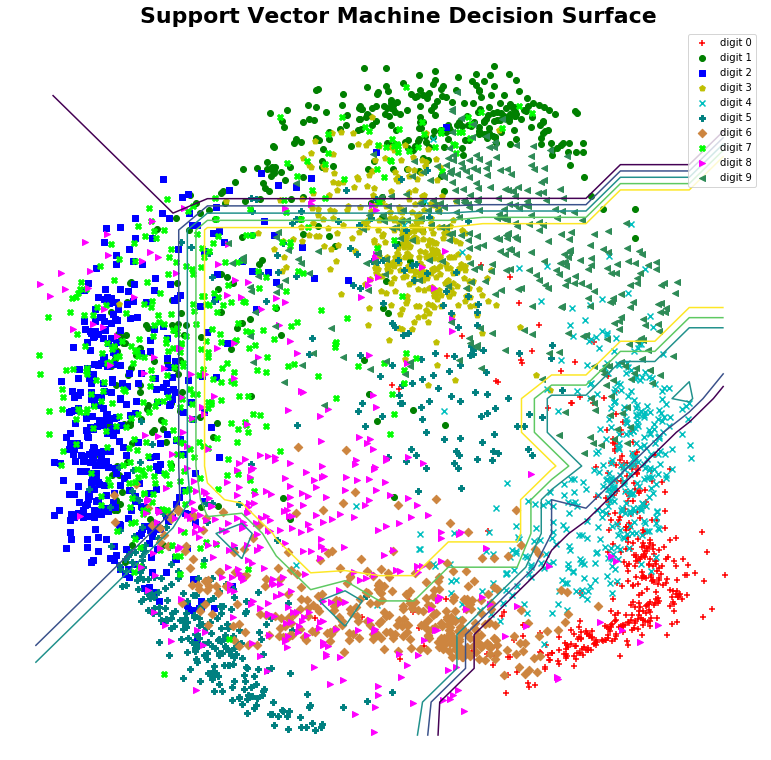

done


In [23]:
plot_multiclass_hyperplane(X_plt=X.copy(), y_plt=Y.copy(), clf_src=ovrsvc, use_annotate=False)